In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.13.1+cu116 True
1.0.0


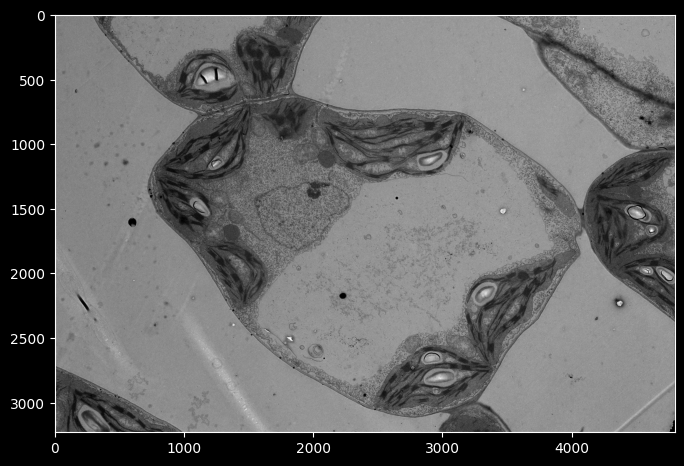

In [2]:
# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt
img = mmcv.imread('/home/MelonSeg/CellData/image/C246.tif')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

# Let's take a look at the segmentation map we got

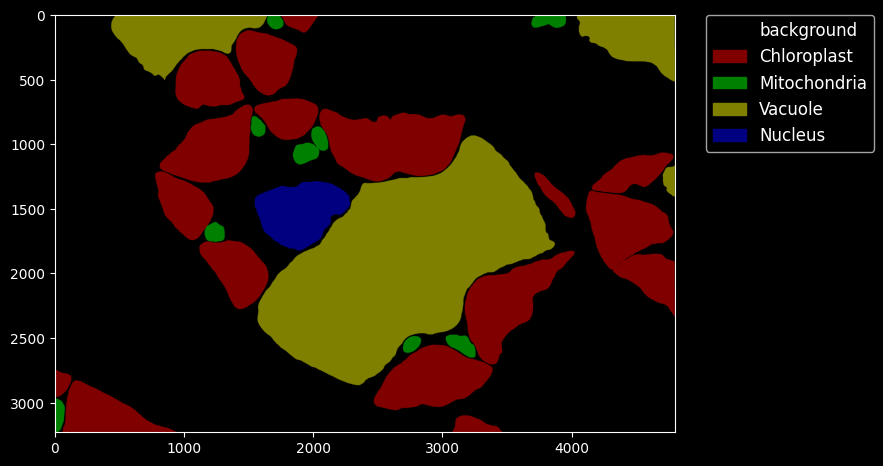

In [3]:
# define dataset root and directory for images and annotations
import os.path as osp
import numpy as np
from PIL import Image
# define class and palette for better visualization
classes = ('background', 'Chloroplast', 'Mitochondria', 'Vacuole', 'Nucleus')
palette = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128]]

# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('/home/MelonSeg/CellData/label/C246.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(5)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [7]:
from mmengine import Config
cfg = Config.fromfile(r'../configs/OrgSegNet/OrgSeg_PlantCell_768x512.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 512))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(512, 512)),
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='OrgSeg_Head',
        in_channels=(256, 512, 1024, 2048),
        in_index=(0, 1, 2, 3),
        channels=512

Since the given config is used to train OrgSegNet on the PlantCell dataset, we need to modify it accordingly for our new dataset.  

In [9]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

cfg.train_dataloader.batch_size = 8

# We should define the data_root of official dataset
# Please make sure the dataset is properly structured according the the guidelines.
data_root = r'../CellData'
img_dir = 'image'
ann_dir = 'label'


cfg.train_dataloader.dataset.data_root = data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'


cfg.val_dataloader.dataset.data_root = data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'


cfg.test_dataloader.dataset.data_root = data_root
cfg.test_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.test_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.test_dataloader.dataset.ann_file = 'splits/test.txt'

# Load the pretrained weights
# cfg.load_from = None
# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/OrgSegNet_Res50_1024maxch'
# Load the pretrained checkpoint.
cfg.load_from = None
# Define the max iterations for the training pipline 
cfg.train_cfg.max_iters = 160000

# The model will be saved every 200 iterations
cfg.default_hooks.checkpoint.interval = 200
# Validation is performed every 200 iterations
cfg.train_cfg.val_interval = 200
cfg.default_hooks.logger.interval = 10

# save newest 5 checkpoints
cfg.default_hooks.checkpoint.max_keep_ckpts = 3
# save best checkpoint based mIoU\ aAcc
cfg.default_hooks.checkpoint.save_best = save_best=['mIoU']
cfg.default_hooks.checkpoint.rule = 'greater'

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)
# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 512))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(512, 512)),
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='OrgSeg_Head',
        in_channels=(256, 512, 1024, 2048),
        in_index=(0, 1, 2, 3),
        channels=512

### Train and Evaluation

In [ ]:
from mmengine.runner import Runner
runner = Runner.from_cfg(cfg)

In [ ]:
# start training
runner.train()

# Inference with trained model

In [10]:
from mmengine import Config
cfg = Config.fromfile(r'./work_dirs/OrgSeg_PlantCell_768x512.py')

In [ ]:
import mmcv
import matplotlib.pyplot as plt
from mmseg.apis import init_model, inference_model, show_result_pyplot, show_cell_pyplot
palette = [[255, 255, 255], [174, 221, 153], [14, 205, 173], [238,137,39], [244, 97, 150]]
# Init the model from the config and the checkpoint
checkpoint_path = './work_dirs/iter_160000.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('../CellData/image/08.tif')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_cell_pyplot(model, img, result, ogrannel=None)
plt.imshow(mmcv.bgr2rgb(vis_result))


##  Then we can trace data

In [ ]:
# Code to segment serial sections  for 3D reconstruction
from mmengine import Config
import mmcv
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from mmseg.apis import init_model, inference_model, show_result_pyplot, show_cell_pyplot

# The serial sections data root
ori_path = xxxx
# output root
out_path = xxxx

# Iterate through the images files to segment the image

for name in os.listdir(ori_path):
    img = Image.open(ori_path + name).convert("RGB")
    h, w, z = np.array(img).shape
    result = inference_model(model, np.array(bmp_image))
    seg_img = np.zeros((h, w, 3))
    palette = [[255, 255, 255], [50, 50, 50], [100, 100, 100], [150,150,150], [200, 200, 200]]

    colors = palette
    result = result.get('pred_sem_seg').get('data').detach().cpu().numpy()

    for c in range(0,5):
        seg_img[:,:,0] += ((result[0][:,:] == c )*( colors[c][0] )).astype('uint8')
        seg_img[:,:,1] += ((result[0][:,:] == c )*( colors[c][1] )).astype('uint8')
        seg_img[:,:,2] += ((result[0][:,:] == c )*( colors[c][2] )).astype('uint8')
    
    seg_img = Image.fromarray(np.uint8(seg_img)).resize([1024,1024], Image.ANTIALIAS)
    # save the segmentation results
    seg_img.save(os.path.join(out_path, name))
